In [1]:
# pull lcl/wb pairs

In [2]:
data_dir = '../split_gen_ihart'

In [3]:
sample_id_to_index = dict()
with open('%s/chr.1.gen.samples.txt' % data_dir, 'r') as f:
    for i, line in enumerate(f):
        sample_id = line.strip()
        sample_id_to_index[sample_id] = i

discard_sample_ids = ['AU3766305', 'AU4078302']
sample_ids, lcl_indices, wb_indices = [], [], []
for sample_id, index in sample_id_to_index.items():
    if sample_id.endswith('_LCL') and sample_id[:-4] not in discard_sample_ids:
        sample_ids.append(sample_id[:-4])
        lcl_indices.append(index)
        wb_indices.append(sample_id_to_index[sample_id[:-4]])

m = len(sample_ids)
print(m)
print(sample_ids)
#print(lcl_indices)
#print(wb_indices)

17
['AU1043304', 'AU2911309', 'AU1860301', 'AU3154301', 'AU3053301', 'AU3646301', 'AU3846302', 'AU3702307', 'AU3761302', 'AU3913302', 'AU3713302', 'AU3051303', 'AU3839303', 'AU4032306', 'AU2410302', 'AU1308303', 'AU4235303']


In [4]:
from itertools import chain

moms = [-1]*m
dads = [-1]*m
siblings = [[] for _ in range(m)]

family_ids = [-1]*m
with open('../data/160826.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[1] in sample_ids:
            i = sample_ids.index(pieces[1])
            family_ids[i] = pieces[0]
            dads[i] = pieces[2]
            moms[i] = pieces[3]
            
with open('../data/160826.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0] in family_ids:
            i = family_ids.index(pieces[0])
            if not pieces[1].endswith('_LCL') and pieces[1] != moms[i] and pieces[1] != dads[i] and pieces[1] != sample_ids[i]:
                siblings[i].append(pieces[1])

print('moms', moms)
print('dads', dads)
print('siblings', siblings)

mom_indices = [sample_id_to_index[sample_id] for sample_id in moms]
dad_indices = [sample_id_to_index[sample_id] for sample_id in dads]
sib_indices = [sample_id_to_index[sample_id] for sample_id in chain.from_iterable(siblings)]



moms ['AU1043202', 'AU2911202', 'AU1860202', 'AU3154202', 'AU3053202', 'AU3646202', 'AU3846202', 'AU3702202', 'AU3761202', 'AU3913202', 'AU3713202', 'AU3051202', 'AU3839202', 'AU4032202', 'AU2410202', 'AU1308202', 'AU4235202']
dads ['AU1043201', 'AU2911201', 'AU1860201', 'AU3154201', 'AU3053201', 'AU3646201', 'AU3846201', 'AU3702201', 'AU3761201', 'AU3913201', 'AU3713201', 'AU3051201', 'AU3839201', 'AU4032201', 'AU2410201', 'AU1308201', 'AU4235201']
siblings [['AU1043301', 'AU1043302', 'AU1043303'], ['AU2911301', 'AU2911302', 'AU2911308'], ['AU1860302', 'AU1860303'], ['AU3154302'], ['AU3053302', 'AU3053303'], ['AU3646302'], ['AU3846301', 'AU3846303'], ['AU3702306', 'AU3702308', 'AU3702309'], ['AU3761301'], ['AU3913301', 'AU3913303', 'AU3913304'], ['AU3713301'], ['AU3051302'], ['AU3839301', 'AU3839302', 'AU3839304'], ['AU4032302', 'AU4032303', 'AU4032304', 'AU4032305', 'AU4032307'], ['AU2410301'], ['AU1308301', 'AU1308302'], ['AU4235301', 'AU4235302']]


In [6]:
from os import listdir
from scipy import sparse
import numpy as np

chroms = [str(i) for i in range(1, 23)]
lcl_genotypes, wb_genotypes = [], []
dad_genotypes, mom_genotypes, sibling_genotypes = [], [], []
positions = []
mismatched_indices = []
lcl_counts, wb_counts = [], []

for chrom in chroms:
    print(chrom, end=' ')
    try:
        sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
        coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
        gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

        # use only "cleaned" variants - must be SNPs
        coordinates = np.load(coord_file)
        snp_positions = coordinates[:, 1]
        is_snp = coordinates[:, 2].astype(bool)
        snp_positions = snp_positions[is_snp]

        data = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[lcl_indices+wb_indices+mom_indices+dad_indices+sib_indices, :] for gen_file in gen_files]).A
        data = data[:, is_snp]
        data[data==-2] = -1

        lcl_genotypes.append(data[:m, :])
        wb_genotypes.append(data[m:(2*m), :])
        mom_genotypes.append(data[(2*m):(3*m), :])
        dad_genotypes.append(data[(3*m):(4*m), :])
        sibling_genotypes.append(data[(4*m):, :])
        positions.append(snp_positions)

        mismatch = np.where(np.any(data[:m] != data[m:(2*m)], axis=0))[0]
        mismatched_indices.append(mismatch)
    except Exception as e:
        print('Error', e)
        lcl_genotypes.append(None)
        wb_genotypes.append(None)
        mom_genotypes.append(None)
        dad_genotypes.append(None)
        sibling_genotypes.append(None)
        positions.append(None)
        mismatched_indices.append(None)
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Error Bad CRC-32 for file 'data.npy'
19 20 21 22 

In [7]:
chrom = '18'
chrom_index = 17
print(chrom, end=' ')

sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# use only "cleaned" variants - must be SNPs
coordinates = np.load(coord_file)
snp_positions = coordinates[:, 1]
is_snp = coordinates[:, 2].astype(bool)
snp_positions = snp_positions[is_snp]

data = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[lcl_indices+wb_indices+mom_indices+dad_indices+sib_indices, :] for gen_file in gen_files]).A
data = data[:, is_snp]
data[data==-2] = -1

lcl_genotypes[chrom_index] = data[:m, :]
wb_genotypes[chrom_index] = data[m:(2*m), :]
mom_genotypes[chrom_index] = data[(2*m):(3*m), :]
dad_genotypes[chrom_index] = data[(3*m):(4*m), :]
sibling_genotypes[chrom_index] = data[(4*m):, :]
positions[chrom_index] = snp_positions

mismatch = np.where(np.any(data[:m] != data[m:(2*m)], axis=0))[0]
mismatched_indices[chrom_index] = mismatch

    

18 

# Take a look at sequencing error patterns

In [8]:
from collections import Counter
confusion_counters = dict()
for chrom, lcl_gen, wb_gen in zip(chroms, lcl_genotypes, wb_genotypes):
    print(chrom, end=' ')
    if lcl_gen is not None and wb_gen is not None:
        for j, sample in enumerate(sample_ids):
            a = np.sum((lcl_gen[j, :]==0) &(wb_gen[j, :]==1)) + np.sum((lcl_gen[j, :]==1) &(wb_gen[j, :]==0))
            b = np.sum((lcl_gen[j, :]==0) &(wb_gen[j, :]==2)) + np.sum((lcl_gen[j, :]==2) &(wb_gen[j, :]==0))
            c = np.sum((lcl_gen[j, :]==1) &(wb_gen[j, :]==2)) + np.sum((lcl_gen[j, :]==2) &(wb_gen[j, :]==1))
            e = np.sum((lcl_gen[j, :]==0) &(wb_gen[j, :]==0))
            f = np.sum((lcl_gen[j, :]==1) &(wb_gen[j, :]==1))
            g = np.sum((lcl_gen[j, :]==2) &(wb_gen[j, :]==2))
            confusion_counters[(chrom, sample)] = (a, b, c, e, f, g)
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [9]:
import matplotlib.pyplot as plt

chrom = '15'

labels = ['0->1', '0->2', '1->2', '0', '1', '2']
plt.figure(figsize=(15, 7))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist([confusion_counters[(chrom, sample_id)][i] for sample_id in sample_ids], bins=20)
    plt.title(labels[i])
    print(labels[i], np.median([confusion_counters[(chrom, sample_id)][i] for sample_id in sample_ids]))

plt.tight_layout()
plt.show()

0->1 4799.0
0->2 64.0
1->2 298.0
0 2037965.0
1 68661.0
2 39654.0


<Figure size 1500x700 with 6 Axes>

In [10]:
chrom = '15'
index = 14
lcl_gen, wb_gen, mom_gen, dad_gen, sib_gen = lcl_genotypes[index], wb_genotypes[index], mom_genotypes[index], dad_genotypes[index], sibling_genotypes[index]



In [11]:
from collections import defaultdict

# first look at trios - what percent of errors occur in non-mendelian trio sites
ok_trios = set([(0, 0, 0), 
                (0, 1, 0), (0, 1, 1), 
                (0, 2, 1), 
                (1, 0, 0), (1, 0, 1),
                (1, 1, 0), (1, 1, 1), (1, 1, 2),
                (1, 2, 1), (1, 2, 2),
                (2, 0, 1),
                (2, 1, 1), (2, 1, 2),
                (2, 2, 2)])

for j in range(len(sample_ids)):
    trio = np.vstack((lcl_gen[j], wb_gen[j], mom_gen[j], dad_gen[j]))
    trio = trio[:, np.all(trio!=-1, axis=0) & np.any(trio!=0, axis=0)]
    
    famgens, counts = np.unique(trio, axis=1, return_counts=True)
    famgen_to_counts = defaultdict(int, [(tuple(fg), c) for (fg, c) in zip(famgens.T, counts)])
    for fg, c in zip(famgens.T, counts):
        if fg[0] != fg[1]:
            print(tuple(fg), c, 
                  c/famgen_to_counts[(fg[0], fg[0], fg[2], fg[3])],
                  c/famgen_to_counts[(fg[1], fg[1], fg[2], fg[3])])
        #if fg[0] == fg[1]:
        #    print(tuple(fg), c, c/sum([c for fg2, c in famgen_to_counts.items() if fg[2]==fg2[2] and fg[3]==fg2[3]]))

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in long_scalars
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in long_scalars


(0, 1, 0, 0) 1141 inf 1.9404761904761905
(0, 1, 0, 1) 432 0.029397754338210274 0.02967848309975268
(0, 1, 0, 2) 11 0.14864864864864866 0.001799738219895288
(0, 1, 1, 0) 309 0.019615311369263 0.020515203824193334
(0, 1, 1, 1) 294 0.0639686684073107 0.018463857313320352
(0, 1, 1, 2) 4 1.0 0.0007763975155279503
(0, 1, 2, 0) 23 0.1678832116788321 0.003906913538304739
(0, 1, 2, 1) 10 0.8333333333333334 0.0019065776930409914
(0, 2, 0, 0) 13 inf 0.5652173913043478
(0, 2, 0, 1) 1 6.805035726437564e-05 0.018518518518518517
(0, 2, 1, 0) 1 6.347997206881229e-05 0.03333333333333333
(0, 2, 1, 2) 2 0.5 0.00039261876717707107
(0, 2, 2, 0) 1 0.0072992700729927005 0.017241379310344827
(1, 0, 0, 0) 865 1.4710884353741496 inf
(1, 0, 0, 1) 468 0.03215169002473207 0.0318475671997278
(1, 0, 0, 2) 35 0.005726439790575916 0.47297297297297297
(1, 0, 1, 0) 336 0.022307794449608287 0.02132927061512093
(1, 0, 1, 1) 280 0.017584626012686053 0.060922541340295906
(1, 0, 1, 2) 16 0.003105590062111801 4.0
(1, 0, 2, 0)

(0, 1, 0, 0) 1160 inf 2.473347547974414
(0, 1, 0, 1) 321 0.017676211453744494 0.024095481158985136
(0, 1, 0, 2) 19 0.1958762886597938 0.004417577307602883
(0, 1, 1, 0) 402 0.025742827868852458 0.026517150395778365
(0, 1, 1, 1) 356 0.08388312912346843 0.02199839337576469
(0, 1, 1, 2) 19 0.6129032258064516 0.0032646048109965637
(0, 1, 2, 0) 25 0.1524390243902439 0.005411255411255411
(0, 1, 2, 1) 8 0.4 0.0018407731247123793
(0, 1, 2, 2) 1 0.5 0.07142857142857142
(0, 2, 0, 0) 18 inf 1.5
(0, 2, 0, 1) 2 0.00011013215859030837 0.006779661016949152
(0, 2, 0, 2) 1 0.010309278350515464 0.02702702702702703
(0, 2, 1, 0) 9 0.0005763319672131147 0.2
(0, 2, 1, 1) 2 0.000471253534401508 0.0003487358326068004
(0, 2, 2, 0) 3 0.018292682926829267 0.02127659574468085
(0, 2, 2, 1) 1 0.05 0.0001595150741745095
(1, 0, 0, 0) 900 1.9189765458422174 inf
(1, 0, 0, 1) 300 0.02251914127007957 0.016519823788546256
(1, 0, 0, 2) 36 0.008370146477563357 0.3711340206185567
(1, 0, 1, 0) 348 0.02295514511873351 0.0222848

(0, 1, 0, 0) 1238 inf 2.413255360623782
(0, 1, 0, 1) 391 0.02392022513153065 0.025498891352549888
(0, 1, 0, 2) 26 0.23214285714285715 0.005603448275862069
(0, 1, 1, 0) 306 0.020884520884520884 0.02050251256281407
(0, 1, 1, 1) 213 0.04101675332177932 0.013536701620591039
(0, 1, 1, 2) 10 0.5 0.0018050541516245488
(0, 1, 2, 0) 26 0.26804123711340205 0.004423273222184417
(0, 1, 2, 1) 8 0.47058823529411764 0.0014414414414414415
(0, 2, 0, 0) 7 inf 0.875
(0, 2, 1, 0) 1 6.825006825006825e-05 0.037037037037037035
(0, 2, 1, 1) 1 0.00019256691700365877 0.00023719165085388995
(1, 0, 0, 0) 1041 2.0292397660818713 inf
(1, 0, 0, 1) 422 0.027520542585104994 0.025816713569068884
(1, 0, 0, 2) 28 0.00603448275862069 0.25
(1, 0, 1, 0) 301 0.02016750418760469 0.020543270543270542
(1, 0, 1, 1) 346 0.021989196059739435 0.06662815328326593
(1, 0, 1, 2) 30 0.005415162454873646 1.5
(1, 0, 2, 0) 37 0.006294658046954746 0.38144329896907214
(1, 0, 2, 1) 23 0.004144144144144144 1.3529411764705883
(1, 0, 2, 2) 1 0.0

(0, 1, 0, 0) 1221 inf 1.4501187648456058
(0, 1, 0, 1) 544 0.029603831084022637 0.035595105672969966
(0, 1, 0, 2) 21 0.17073170731707318 0.0036719706242350062
(0, 1, 1, 0) 341 0.02107800717023118 0.020969130488254828
(0, 1, 1, 1) 283 0.05100018021265093 0.01818532322323609
(0, 1, 1, 2) 6 0.045112781954887216 0.0011307953260459858
(0, 1, 2, 0) 22 0.23404255319148937 0.004623791509037411
(0, 1, 2, 1) 19 1.2666666666666666 0.0037556829412927458
(0, 2, 0, 0) 4 inf 0.36363636363636365
(0, 2, 0, 1) 1 5.4418807139747494e-05 0.022727272727272728
(0, 2, 1, 0) 2 0.00012362467548522686 0.08
(0, 2, 2, 0) 2 0.02127659574468085 0.06451612903225806
(1, 0, 0, 0) 962 1.1425178147268409 inf
(1, 0, 0, 1) 503 0.03291238631158804 0.02737265999129299
(1, 0, 0, 2) 27 0.004721105088302151 0.21951219512195122
(1, 0, 1, 0) 317 0.019493297257409913 0.019594511064408456
(1, 0, 1, 1) 281 0.018056805037912866 0.05063975491079474
(1, 0, 1, 2) 19 0.003580851865812288 0.14285714285714285
(1, 0, 2, 0) 29 0.0060949978982

(0, 1, 0, 0) 1220 inf 2.3106060606060606
(0, 1, 0, 1) 674 0.038228120923373604 0.03646988799307397
(0, 1, 0, 2) 26 0.40625 0.005780346820809248
(0, 1, 1, 0) 383 0.020764434806180537 0.022048241321743135
(0, 1, 1, 1) 296 0.041831543244771056 0.020898051397910195
(0, 1, 1, 2) 5 0.38461538461538464 0.001051745898190997
(0, 1, 2, 0) 31 0.20945945945945946 0.006295694557270512
(0, 1, 2, 1) 17 0.6538461538461539 0.0030730296456977584
(0, 1, 2, 2) 1 1.0 0.05555555555555555
(0, 2, 0, 0) 10 inf 0.2777777777777778
(0, 2, 0, 1) 3 0.00017015484090522376 0.06818181818181818
(0, 2, 0, 2) 2 0.03125 0.03125
(0, 2, 1, 0) 2 0.00010843046896177825 0.05
(0, 2, 1, 1) 1 0.00014132278123233464 0.00015659254619480113
(0, 2, 2, 1) 2 0.07692307692307693 0.00038248231019315357
(0, 2, 2, 2) 2 2.0 8.750437521876094e-05
(1, 0, 0, 0) 876 1.6590909090909092 inf
(1, 0, 0, 1) 477 0.025810291650884692 0.027054619703930576
(1, 0, 0, 2) 32 0.007114273010226767 0.5
(1, 0, 1, 0) 369 0.021242300385700304 0.02000542152344809


In [12]:
from collections import defaultdict, Counter

def counter_to_confusion(confusion_counter, values=[-1, 0, 1, 2]):
    b = np.zeros((len(values), len(values)), dtype=int)
    
    for j in range(len(values)):
        for k in range(len(values)):
            if (values[j], values[k]) in confusion_counter:
                b[j, k] = confusion_counter[(values[j], values[k])]
    return b

def plot_with_cell_labels(b, labels):
    if np.max(b) <= 1:
        plt.imshow(b, vmin=0, vmax=1)
    else:
        plt.imshow(b, vmin=0, vmax=100000)
    plt.xticks(range(4), labels)
    plt.yticks(range(4), labels)
    
    # Add the text
    for (j,k),label in np.ndenumerate(b):
        if label < .1:
            label = '{:.2%}'.format(label)
            col = 'white'
        elif label < 1:
            label = '{:.2%}'.format(label)
            col = 'black'
        elif label>30000:
            col = 'black'
        else:
            col = 'white'
        plt.text(k,j, label,ha='center',va='center', color=col)
        plt.text(k,j, label,ha='center',va='center', color=col)
    plt.xlabel('LCL')
    plt.ylabel('WB')
    

plt.figure(figsize=(15, 15))

# LCL first then WB
for i, chrom in enumerate(chroms):
    b = counter_to_confusion(confusion_counters[(chrom, 'overall')])
                
    plt.subplot(3, len(chroms), i+1)
    plot_with_cell_labels(b, [-1, 0, 1, 2])
    plt.title(chrom)
    
    plt.subplot(3, len(chroms), i+1+len(chroms))
    plot_with_cell_labels(b/np.sum(b, axis=0), [-1, 0, 1, 2])
    
    plt.subplot(3, len(chroms), i+1+2*len(chroms))
    plot_with_cell_labels((b.T/np.sum(b, axis=1)).T, [-1, 0, 1, 2])
            
plt.tight_layout()
plt.show()

KeyError: ('1', 'overall')

<Figure size 1080x1080 with 0 Axes>

In [13]:
plt.figure(figsize=(15, 20))

chrom_limits = [1, 1, 1]
hom_ref_data, het_data, hom_alt_data = [], [], []
for i, chrom in enumerate(chroms):
    lcl_accuracy, wb_accuracy = [], []
    for j, sample in enumerate(sample_ids):
        b = counter_to_confusion(confusion_counters[(chrom, sample)], values=[0, 1, 2])
            
        lcl_accuracy.append(np.diag(b/np.sum(b, axis=0)))
        wb_accuracy.append(np.diag(b.T/np.sum(b, axis=1)))
        
        cat_vector = [1] + [1 if x==chrom else 0 for x in chroms[1:]] + [1 if x==sample else 0 for x in sample_ids[1:]]
        
        hom_ref_data.append(cat_vector + [0, lcl_accuracy[-1][0]])
        hom_ref_data.append(cat_vector + [1, wb_accuracy[-1][0]])
        het_data.append(cat_vector + [0, lcl_accuracy[-1][1]])
        het_data.append(cat_vector + [1, wb_accuracy[-1][1]])
        hom_alt_data.append(cat_vector + [0, lcl_accuracy[-1][2]])
        hom_alt_data.append(cat_vector + [1, wb_accuracy[-1][2]])
        
        
    plt.subplot(3, 1, 1, aspect='equal')
    plt.scatter([x[0] for x in lcl_accuracy], [x[0] for x in wb_accuracy], label=chrom)

    plt.subplot(3, 1, 2, aspect='equal')
    plt.scatter([x[1] for x in lcl_accuracy], [x[1] for x in wb_accuracy], label=chrom)

    plt.subplot(3, 1, 3, aspect='equal')
    plt.scatter([x[2] for x in lcl_accuracy], [x[2] for x in wb_accuracy], label=chrom)

    chrom_limits[0] = min(min([x[0] for x in lcl_accuracy]), chrom_limits[0])
    chrom_limits[1] = min(min([x[1] for x in lcl_accuracy]), chrom_limits[1])
    chrom_limits[2] = min(min([x[2] for x in lcl_accuracy]), chrom_limits[2])
    
plt.subplot(3, 1, 1, aspect='equal')
plt.title('Hom Ref')
plt.xlim([chrom_limits[0], 1])
plt.ylim([chrom_limits[0], 1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", color='black')
plt.xlabel('LCL')
plt.ylabel('WB')
plt.legend()
    
plt.subplot(3, 1, 2, aspect='equal')
plt.title('Het')
plt.xlim([chrom_limits[1], 1])
plt.ylim([chrom_limits[1], 1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", color='black')
plt.xlabel('LCL')
plt.ylabel('WB')
plt.legend()
    
plt.subplot(3, 1, 3, aspect='equal')
plt.title('Hom Alt')
plt.xlim([chrom_limits[2], 1])
plt.ylim([chrom_limits[2], 1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", color='black')
plt.xlabel('LCL')
plt.ylabel('WB')
plt.legend()
    
plt.tight_layout()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1080x1440 with 0 Axes>

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

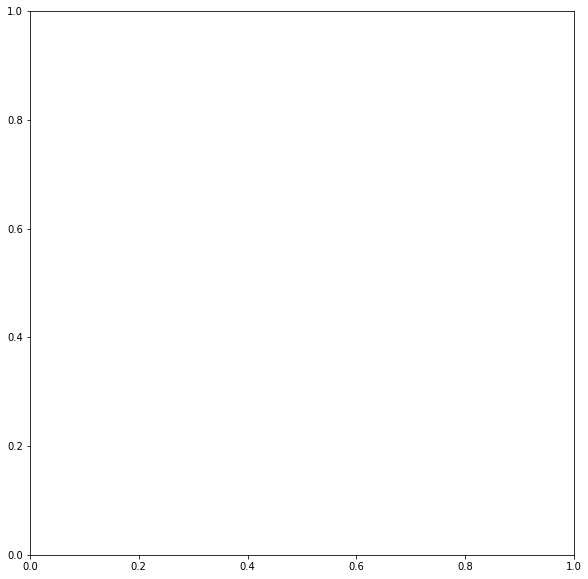

In [14]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1, aspect='equal')

max_lim = 0
missing_data = []
for chrom in chroms:
    missing_lcl, missing_wb = [], []
    for sample in sample_ids:
        b = counter_to_confusion(confusion_counters[(chrom, sample)], values=[-1, 0, 1, 2])
        missing_lcl.append(np.sum(b, axis=1)[0])
        missing_wb.append(np.sum(b, axis=0)[0])
        
        cat_vector = [1] + [1 if x==chrom else 0 for x in chroms[1:]] + [1 if x==sample else 0 for x in sample_ids[1:]]
        
        missing_data.append(cat_vector + [0, missing_lcl[-1]])
        missing_data.append(cat_vector + [1, missing_wb[-1]])
    
    plt.scatter(missing_lcl, missing_wb, label=chrom)
    max_lim = max(max_lim, max(missing_lcl + missing_wb))
    
plt.title('Missing')
plt.xlim([0, max_lim])
plt.ylim([0, max_lim])
plt.plot(plt.xlim(), plt.ylim(), ls="--", color='black')
plt.xlabel('LCL')
plt.ylabel('WB')
plt.legend()

In [247]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math

hom_ref_data = np.asarray(hom_ref_data)
X = hom_ref_data[:, :-1]
y = hom_ref_data[:, -1]

model = sm.OLS(y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1])

offset 0.0
chrom [2.55532885e-56 4.17083135e-11 2.34049989e-43 8.78907500e-61]
inds [3.73394716e-05 1.13227759e-02 1.43480142e-03 1.34927726e-01
 1.83069740e-01 7.11421722e-02 1.81023728e-02 5.37086797e-02
 2.47752057e-02 2.52820785e-02 5.00873257e-01 2.35204272e-01
 2.28596201e-03 5.65466014e-03 6.82201003e-01]
lcl/wb 0.1998368577304468


In [246]:
het_data = np.asarray(het_data)
X = het_data[:, :-1]
y = het_data[:, -1]

model = sm.OLS(y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1])

offset 6.071189792907015e-262
chrom [2.72321660e-20 2.60724738e-22 8.75544034e-39 3.24370850e-61]
inds [0.19970818 0.01030205 0.01831239 0.02478839 0.50775811 0.64192759
 0.08479342 0.01683163 0.00131363 0.0389474  0.305394   0.01989943
 0.00069474 0.00346563 0.24314483]
lcl/wb 0.423208115138175


In [245]:
hom_alt_data = np.asarray(hom_alt_data)
X = hom_alt_data[:, :-1]
y = hom_alt_data[:, -1]

model = sm.OLS(y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1])

offset 0.0
chrom [5.35680202e-13 5.02770514e-33 1.71437451e-15 1.80209702e-38]
inds [0.25534299 0.31931399 0.39034281 0.36256767 0.08392463 0.06430331
 0.09856676 0.67841334 0.86616354 0.37010816 0.82096633 0.21210399
 0.45630448 0.11099885 0.54406277]
lcl/wb 1.763811742960871e-05


In [249]:
missing_data = np.asarray(missing_data)
X = missing_data[:, :-1]
y = missing_data[:, -1]

model = sm.OLS(y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1])

offset 7.751904848653672e-43
chrom [7.91821109e-09 6.35318459e-30 7.37906778e-01 4.60227021e-31]
inds [0.50852666 0.48432862 0.12904631 0.99138308 0.64174938 0.20349043
 0.01697692 0.58355306 0.04623549 0.57459583 0.04476633 0.30611774
 0.31171225 0.08250904 0.21524423]
lcl/wb 1.628637119169881e-11


# when LCL gets homalt wrong does it make different errors than WB?

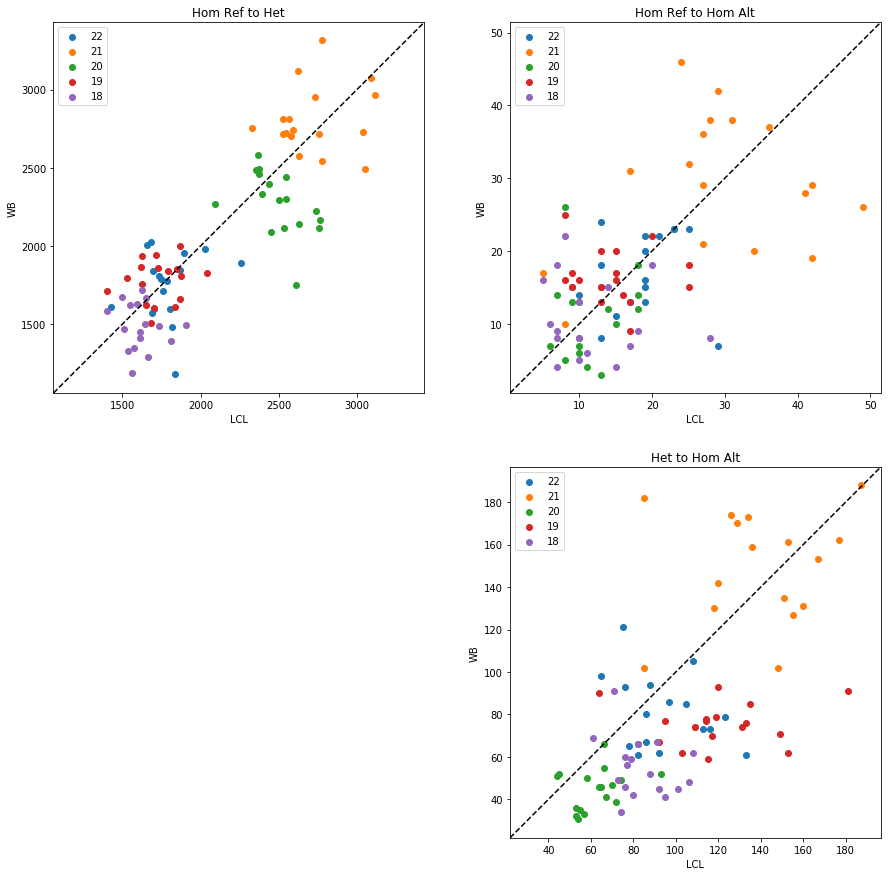

In [301]:
plt.figure(figsize=(15, 15))

chrom_limits = [0, 0]
homref_to_het_y, homref_to_homalt_y, het_to_homalt_y = [], [], []
for i, chrom in enumerate(chroms):
    all_samples = np.asarray([counter_to_confusion(confusion_counters[(chrom, sample)], values=[0, 1, 2]) for sample in sample_ids])
        
    plt.subplot(2, 2, 1, aspect='equal')
    plt.scatter(all_samples[:, 0, 1], all_samples[:, 1, 0], label=chrom)

    plt.subplot(2, 2, 2, aspect='equal')
    plt.scatter(all_samples[:, 0, 2], all_samples[:, 2, 0], label=chrom)
    
    plt.subplot(2, 2, 4, aspect='equal')
    plt.scatter(all_samples[:, 1, 2], all_samples[:, 2, 1], label=chrom)
    
    for a, b in zip(all_samples[:, 0, 1], all_samples[:, 1, 0]):
        homref_to_het_y.append(a)
        homref_to_het_y.append(b)
        
    for a, b in zip(all_samples[:, 0, 2], all_samples[:, 2, 0]):
        homref_to_homalt_y.append(a)
        homref_to_homalt_y.append(b)
        
    for a, b in zip(all_samples[:, 1, 2], all_samples[:, 2, 1]):
        het_to_homalt_y.append(a)
        het_to_homalt_y.append(b)
        

plt.subplot(2, 2, 1, aspect='equal')
plt.title('Hom Ref to Het')
plt.xlim([min(plt.xlim()+plt.ylim()), max(plt.xlim()+plt.ylim())])
plt.ylim([min(plt.xlim()+plt.ylim()), max(plt.xlim()+plt.ylim())])
plt.plot(plt.xlim(), plt.ylim(), ls="--", color='black')
plt.xlabel('LCL')
plt.ylabel('WB')
plt.legend()
    
plt.subplot(2, 2, 2, aspect='equal')
plt.title('Hom Ref to Hom Alt')
plt.xlim([min(plt.xlim()+plt.ylim()), max(plt.xlim()+plt.ylim())])
plt.ylim([min(plt.xlim()+plt.ylim()), max(plt.xlim()+plt.ylim())])
plt.plot(plt.xlim(), plt.ylim(), ls="--", color='black')
plt.xlabel('LCL')
plt.ylabel('WB')
plt.legend()

plt.subplot(2, 2, 4, aspect='equal')
plt.title('Het to Hom Alt')
plt.xlim([min(plt.xlim()+plt.ylim()), max(plt.xlim()+plt.ylim())])
plt.ylim([min(plt.xlim()+plt.ylim()), max(plt.xlim()+plt.ylim())])
plt.plot(plt.xlim(), plt.ylim(), ls="--", color='black')
plt.xlabel('LCL')
plt.ylabel('WB')
plt.legend()
    
#plt.tight_layout()
plt.show()

In [295]:
model = sm.OLS(homref_to_het_y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1], result.params[-1])

offset 6.637066793656007e-56
chrom [3.99512729e-51 5.85511334e-30 7.68514543e-01 1.70856837e-06]
inds [1.17455452e-04 6.09478072e-03 1.31700531e-03 8.97603457e-02
 1.71414640e-01 5.49726774e-02 6.27675963e-03 2.54989745e-02
 1.65581042e-02 9.16804744e-03 4.24740069e-01 2.40686049e-01
 1.22707110e-03 8.09252829e-03 6.63864119e-01]
lcl/wb 0.05174216961906266 -53.44705882352741


In [296]:
model = sm.OLS(homref_to_homalt_y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1], result.params[-1])

offset 9.240374390563802e-13
chrom [1.00751432e-11 8.21971115e-05 2.04254047e-01 7.64699795e-05]
inds [0.4480452  0.17955196 0.78245862 0.05473247 0.86297657 0.27031582
 0.65372439 0.83593251 0.38874823 0.91752237 0.28551037 0.73000378
 0.24163022 0.70423013 0.35203653]
lcl/wb 0.9057535511681305 -0.11764705882352189


In [299]:
model = sm.OLS(het_to_homalt_y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1], result.params[-1])

offset 2.449698841548043e-22
chrom [1.76646389e-19 6.83942213e-10 4.46284378e-02 6.33164396e-04]
inds [0.27112955 0.9581219  0.41322054 0.94139677 0.10734684 0.07241434
 0.14868828 0.54966645 0.42527418 0.19054748 0.51526161 0.05612936
 0.36155848 0.01540507 0.97486568]
lcl/wb 1.4477573081749742e-08 -19.564705882352868


In [269]:
homref_to_homalt_data = np.asarray(homref_to_homalt_data)
X = homref_to_homalt_data[:, :-1]
y = homref_to_homalt_data[:, -1]

model = sm.OLS(y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1])

offset 9.240374390563802e-13
chrom [1.00751432e-11 8.21971115e-05 2.04254047e-01 7.64699795e-05]
inds [0.4480452  0.17955196 0.78245862 0.05473247 0.86297657 0.27031582
 0.65372439 0.83593251 0.38874823 0.91752237 0.28551037 0.73000378
 0.24163022 0.70423013 0.35203653]
lcl/wb 0.9057535511681305


In [270]:
het_to_homref_data = np.asarray(het_to_homref_data)
X = het_to_homref_data[:, :-1]
y = het_to_homref_data[:, -1]

model = sm.OLS(y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1])

offset 3.648068281821906e-54
chrom [3.99512729e-51 5.85511334e-30 7.68514543e-01 1.70856837e-06]
inds [1.17455452e-04 6.09478072e-03 1.31700531e-03 8.97603457e-02
 1.71414640e-01 5.49726774e-02 6.27675963e-03 2.54989745e-02
 1.65581042e-02 9.16804744e-03 4.24740069e-01 2.40686049e-01
 1.22707110e-03 8.09252829e-03 6.63864119e-01]
lcl/wb 0.05174216961904788


In [271]:
het_to_homalt_data = np.asarray(het_to_homalt_data)
X = het_to_homalt_data[:, :-1]
y = het_to_homalt_data[:, -1]

model = sm.OLS(y, X)
result = model.fit()
#result.summary()
print('offset', result.pvalues[0])
print('chrom', result.pvalues[1:len(chroms)])
print('inds', result.pvalues[len(chroms):(len(chroms)-1 + len(sample_ids)-1)])
print('lcl/wb', result.pvalues[-1])

offset 2.449698841548043e-22
chrom [1.76646389e-19 6.83942213e-10 4.46284378e-02 6.33164396e-04]
inds [0.27112955 0.9581219  0.41322054 0.94139677 0.10734684 0.07241434
 0.14868828 0.54966645 0.42527418 0.19054748 0.51526161 0.05612936
 0.36155848 0.01540507 0.97486568]
lcl/wb 1.4477573081749742e-08


In [275]:
print(homref_to_homalt_data[:, -1])
print(homalt_to_homref_data[:, -1])

[21 22 13  8 19 15 13 15 13 24 17 13 23 23 29  7 19 16 19 22 19 20 13 18
 25 23 23 23 10 14 15 11 19 13 49 26 27 21  5 17 42 29  8 10 31 38 27 29
 29 42 24 46 17 31 42 19 25 32 41 28 36 37 27 36 34 20 28 38 10  7  9 13
 11  4 18 12 10  8 15 10  9 15 18 18  8 26 10  6 14 12  8  5  6  7 18 14
  7 14 13  3 10 13  8 16 10 16 20 22  8 25 15 16  9 17 25 18 13 13  9 15
 17 13 15 20 15 17 17  9 13 20 25 15 13 15 16 14  6 10 28  8 10 13  5 16
 10  5  8 22 20 18 15  4 10  8  7  8 11  6  7  4 14 15  7 18  7  9 17  7
 18  9]
[22 21  8 13 15 19 15 13 24 13 13 17 23 23  7 29 16 19 22 19 20 19 18 13
 23 25 23 23 14 10 11 15 13 19 26 49 21 27 17  5 29 42 10  8 38 31 29 27
 42 29 46 24 31 17 19 42 32 25 28 41 37 36 36 27 20 34 38 28  7 10 13  9
  4 11 12 18  8 10 10 15 15  9 18 18 26  8  6 10 12 14  5  8  7  6 14 18
 14  7  3 13 13 10 16  8 16 10 22 20 25  8 16 15 17  9 18 25 13 13 15  9
 13 17 20 15 17 15  9 17 20 13 15 25 15 13 14 16 10  6  8 28 13 10 16  5
  5 10 22  8 18 20  4 15  8 10  8  7  6 11 

# Compare missing

1 1.1416272246630799
2 1.2186487725286816
3 1.2607004356130347
4 1.1421267384658045
5 1.2043692094821548
6 1.2153551221671637
7 1.1304284070536765
8 1.097380483762231
9 1.0505370817424136
10 1.1617768555393022
11 1.212516837480416
12 1.3271341222774367
13 1.273795746647897
14 1.0537162616160713
15 1.1475396810552123
16 1.2606499612235378
17 1.3336557091731744
18 1.2849309781304863
19 1.3771783903749084
20 1.3148771665910286
21 1.0539740458116273
22 1.136679313128315


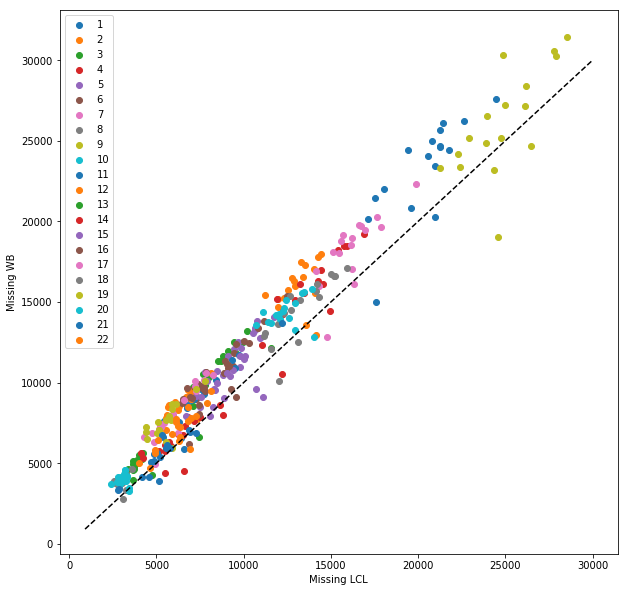

In [19]:
plt.figure(figsize=(10, 10))

for i, chrom in enumerate(chroms):
    missing_lcl = np.sum(lcl_genotypes[i]<0, axis=1)
    missing_wb = np.sum(wb_genotypes[i]<0, axis=1)
    print(chrom, np.mean(missing_wb/missing_lcl))
    
    plt.scatter(missing_lcl, missing_wb, label=chrom)
    
plt.plot(plt.xlim(), plt.xlim(), linestyle='--', color='black')
plt.xlabel('Missing LCL')
plt.ylabel('Missing WB')
plt.legend()
plt.show()

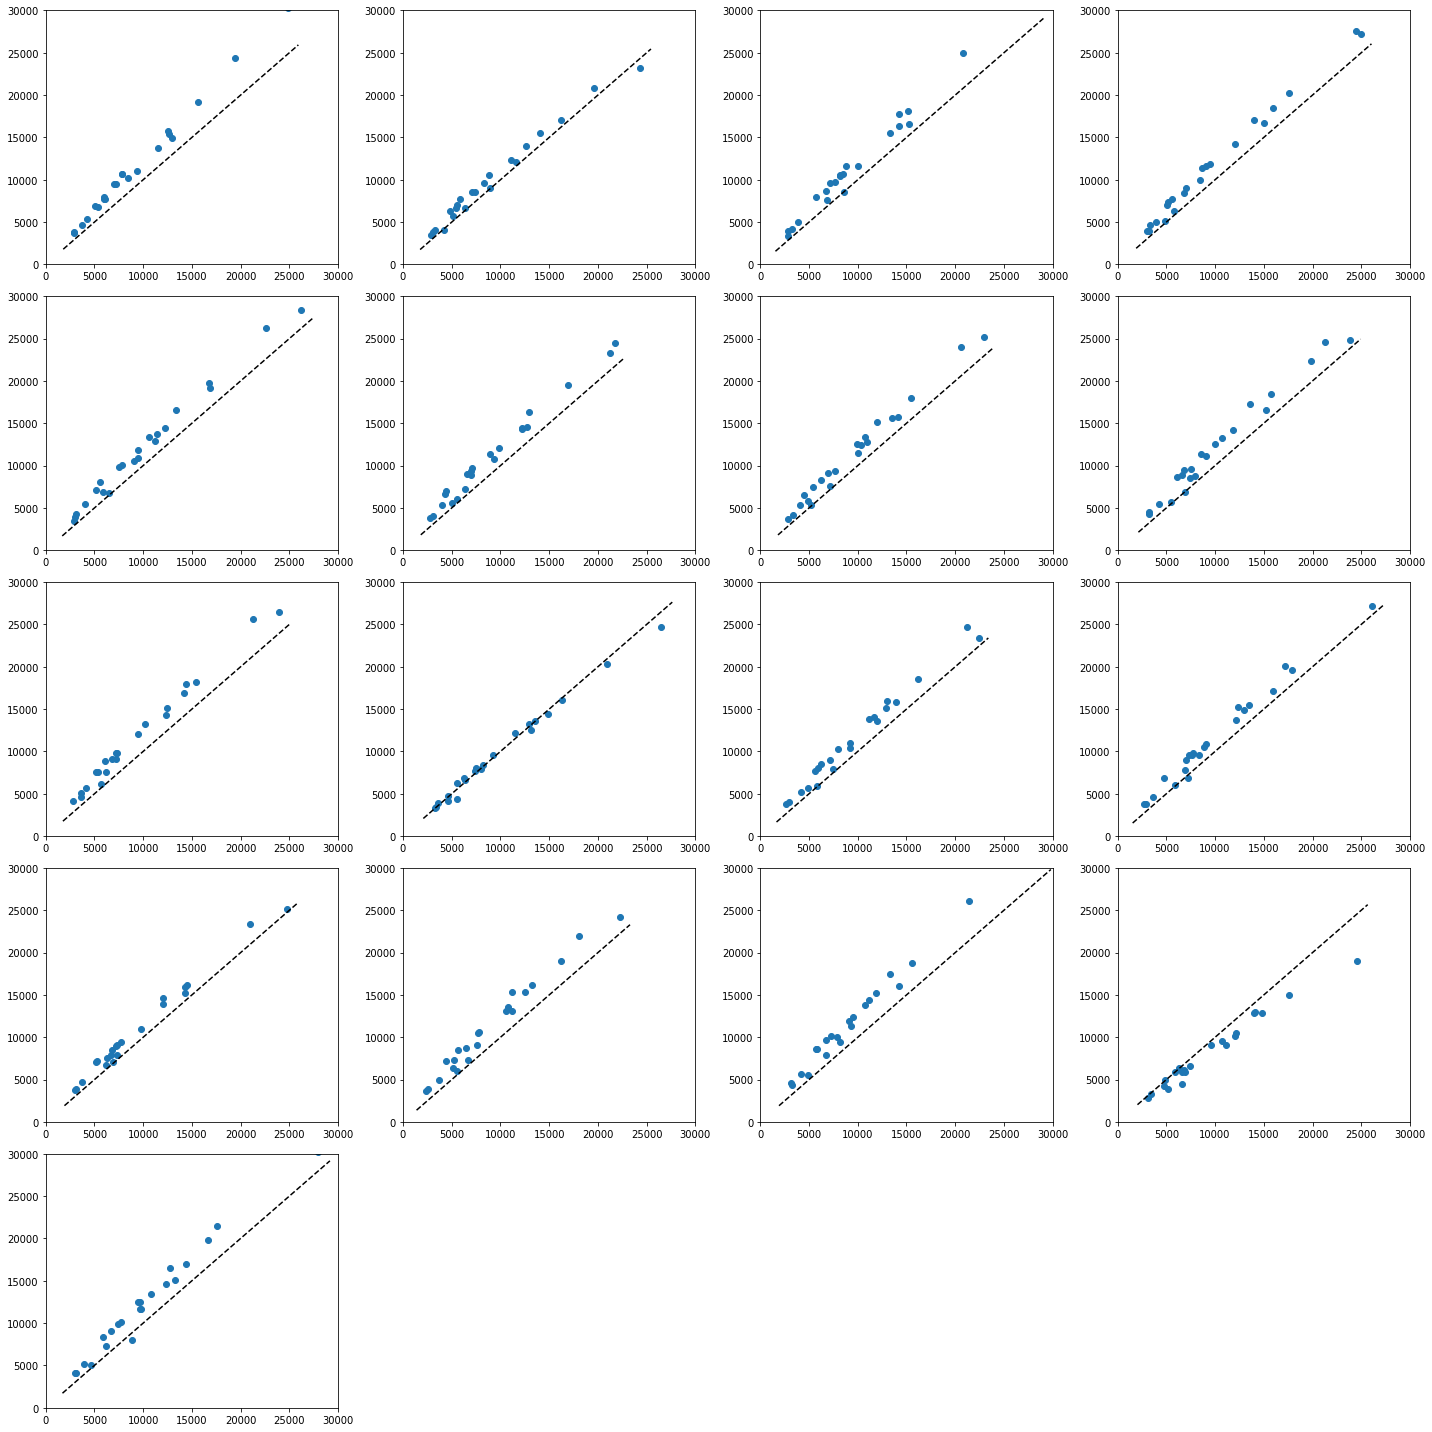

In [57]:
plt.figure(figsize=(20, 20))

for j in range(17):
    plt.subplot(5, 4, j+1)
    missing_lcl = [np.sum(lcl_genotypes[i][j, :]<0) for i in range(22)]
    missing_wb = [np.sum(wb_genotypes[i][j, :]<0) for i in range(22)]
    
    plt.scatter(missing_lcl, missing_wb, label=str(j))
    plt.plot(plt.xlim(), plt.xlim(), linestyle='--', color='black')
    plt.xlim([0, 30000])
    plt.ylim([0, 30000])
#plt.xlabel('Missing LCL')
#plt.ylabel('Missing WB')
#plt.legend()

plt.tight_layout()
plt.show()

# Pull depth in MT

In [20]:
chrom = 'MT'
print(chrom, end=' ')

sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# use only "cleaned" variants - must be SNPs
coordinates = np.load(coord_file)
snp_positions = coordinates[:, 1]
is_snp = coordinates[:, 2].astype(bool)
snp_positions = snp_positions[is_snp]

data = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[lcl_indices+wb_indices+mom_indices+dad_indices+sib_indices, :] for gen_file in gen_files]).A
data = data[:, is_snp]
data[data==-2] = -1

mt_lcl_genotypes = data[:m, :]
mt_wb_genotypes = data[m:(2*m), :]
mt_mom_genotypes = data[(2*m):(3*m), :]
mt_dad_genotypes = data[(3*m):(4*m), :]
mt_sibling_genotypes = data[(4*m):, :]
mt_positions = snp_positions

mismatch = np.where(np.any(data[:m] != data[m:(2*m)], axis=0))[0]
mt_mismatched_indices = mismatch

    

MT 

In [40]:
print(missing_lcl, missing_wb)


[0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0] [0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1]


In [28]:
from collections import defaultdict
import numpy as np
from scipy.sparse import csc_matrix, save_npz
import time
import gzip
from itertools import product
import sys

t0 = time.time()

# Pull arguments
vcf_file = '../data/MT.reheader.vcf.gz'
chrom = 'MT'

depth_lcl = np.zeros(mt_lcl_genotypes.shape, dtype=int)
depth_wb = np.zeros(mt_wb_genotypes.shape, dtype=int)

# Pull data from vcf
pos_index = 0
with gzip.open(vcf_file, 'rt') as f:

    # Skip header
    line = next(f)
    while line.startswith('##'):
        line = next(f)

    # Pull depth from vcf
    m = len(sample_ids)
    
    line = next(f)
    for j, line in enumerate(f):
        pieces = line.split('\t')

        if pieces[0] == chrom or (chrom == 'X' and pieces[0] == '23') or (chrom == 'Y' and pieces[0] == '24'):

            format = pieces[8].strip().split(':')
            pos, _, ref, alt = pieces[1:5]
            is_biallelic_snp = 1 if len(ref) == 1 and len(alt) == 1 and ref != '.' and alt != '.' else 0

            if is_biallelic_snp == 1:
                # Pull out genotypes
                if 'DP' in format:
                    dp_index = format.index('DP')

                    for i, index in enumerate(lcl_indices):
                        segment = pieces[9+index].split(':', maxsplit=dp_index+1)
                        depth_lcl[i, pos_index] = int(segment[dp_index])

                    for i, index in enumerate(wb_indices):
                        segment = pieces[9+index].split(':', maxsplit=dp_index+1)
                        depth_wb[i, pos_index] = int(segment[dp_index])
                pos_index += 1

print('Completed in ', time.time()-t0, 'sec')



Completed in  3.923680067062378 sec


In [61]:
from collections import defaultdict
import numpy as np
from scipy.sparse import csc_matrix, save_npz
import time
import gzip
from itertools import product
import sys

t0 = time.time()

# Pull arguments
vcf_file = '../data/22.reheader.vcf.gz'
chrom = '22'

depth_lcl22 = np.zeros(lcl_genotypes[-1].shape, dtype=int)
depth_wb22 = np.zeros(wb_genotypes[-1].shape, dtype=int)

# Pull data from vcf
pos_index = 0
with gzip.open(vcf_file, 'rt') as f:

    # Skip header
    line = next(f)
    while line.startswith('##'):
        line = next(f)

    # Pull depth from vcf
    m = len(sample_ids)
    
    line = next(f)
    for j, line in enumerate(f):
        pieces = line.split('\t')

        if pieces[0] == chrom or (chrom == 'X' and pieces[0] == '23') or (chrom == 'Y' and pieces[0] == '24'):

            format = pieces[8].strip().split(':')
            pos, _, ref, alt = pieces[1:5]
            is_biallelic_snp = 1 if len(ref) == 1 and len(alt) == 1 and ref != '.' and alt != '.' else 0

            if is_biallelic_snp == 1:
                # Pull out genotypes
                if 'DP' in format:
                    dp_index = format.index('DP')

                    for i, index in enumerate(lcl_indices):
                        segment = pieces[9+index].split(':', maxsplit=dp_index+1)
                        if segment[dp_index] != '.':
                            depth_lcl22[i, pos_index] = int(segment[dp_index])

                    for i, index in enumerate(wb_indices):
                        segment = pieces[9+index].split(':', maxsplit=dp_index+1)
                        if segment[dp_index] != '.':
                            depth_wb22[i, pos_index] = int(segment[dp_index])
                pos_index += 1

print('Completed in ', time.time()-t0, 'sec')



FileNotFoundError: [Errno 2] No such file or directory: '../data/21.reheader.vcf.gz'

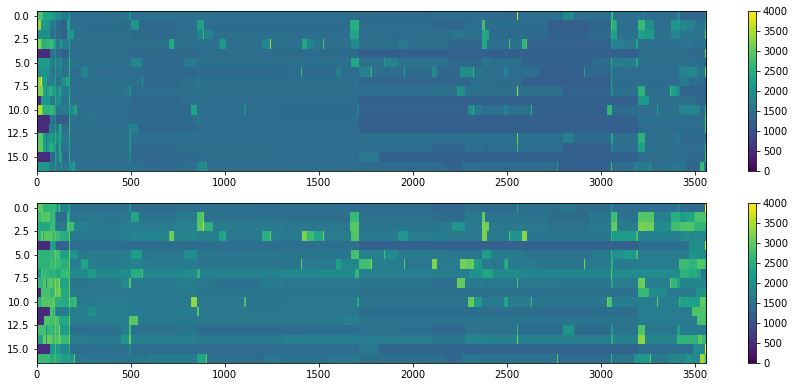

In [33]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(depth_lcl, aspect='auto', vmin=0, vmax=4000)
plt.colorbar()

plt.subplot(3, 1, 2)
plt.imshow(depth_wb, aspect='auto', vmin=0, vmax=4000)
plt.colorbar()

plt.show()

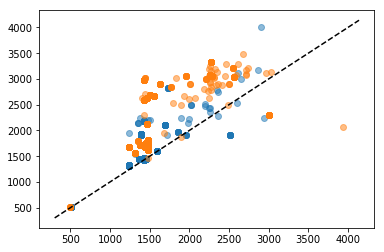

In [56]:
plt.scatter(depth_lcl[-2, :], depth_wb[-2, :], alpha=0.5)
plt.scatter(depth_lcl[-3, :], depth_wb[-3, :], alpha=0.5)

plt.plot(plt.xlim(), plt.xlim(), linestyle='--', color='black')

plt.show()

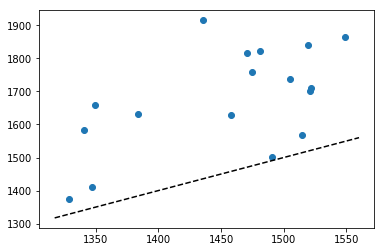

In [43]:
plt.scatter(np.mean(depth_lcl, axis=1), np.mean(depth_wb, axis=1))
plt.plot(plt.xlim(), plt.xlim(), linestyle='--', color='black')


In [50]:
print(np.median(depth_lcl), np.median(depth_wb))

1446.0 1582.0


In [45]:
print(np.max(depth_lcl), np.max(depth_wb))

4905 4232
